In [1]:
## lets import necessary packages
## conda env compare_PSD
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV

In [2]:
## Lets load the data

full_df = pd.read_pickle("full_df_2021_CO2.pkl")
pd.set_option('display.max_columns', None)

## This the data cleaning. Keeping only the relevant features and removing the less than equal to zero target values

cols_1=[i for i in range(1,16) ] ## an example of list comprehension
cols_2=[i for i in range(17,22)]
cols=cols_1+cols_2
cols.append(23)

df1= full_df.drop(full_df.columns[cols], axis=1) ## delete these columns

j=[]
for i in range(4,72):
    j.append(i)

df2 = df1.drop(df1.columns[j], axis=1)
df3 = df2.drop(df2.columns[[11,12,13,14,15,16,17,18]], axis=1)

## we will need to treat the \ character as a \ character rather 
## than escape character, so the letter r needs to be added before the string


df3.rename(columns={'pda': 'Average Pupil Diameter (mm)', 'pup_dis': 'Pupil Distance (mm)',
                    'pd_diff_abs': '|Difference in Pupil Diameter| (mm)', 'ECG.': r'ECG ($\mathrm{\mu V}$)',
                    'Resp.': 'Respiration Rate (brpm)','Temp.': r'Skin Temperature ($\mathrm{^o C})$',
                    'HR': 'Heart Rate (bpm)','CO2':r'$\mathrm{CO_2}$ (ppm)','SpO2':r'$\mathrm{SpO_2}$ (%)',
                    'GSR':r'GSR ($\mathrm{\mu S}$)'}, inplace=True)

## Lets change some of variables to standard units

df3[r'$\mathrm{SpO_2}$ (%)']=df3[r'$\mathrm{SpO_2}$ (%)']*1000000 ## change the SpO2 to percentage

df3[r'GSR ($\mathrm{\mu S}$)']=df3[r'GSR ($\mathrm{\mu S}$)']*1000 ## convert kiloohms to ohms
df3[r'GSR ($\mathrm{\mu S}$)']=1/df3[r'GSR ($\mathrm{\mu S}$)']  ## convert ohms to siemans by taking the reciprocal
df3[r'GSR ($\mathrm{\mu S}$)']=df3[r'GSR ($\mathrm{\mu S}$)']*1000000 ## convert siemens to microsiemens

df3 = df3.drop(df3.columns[6], axis=1) ## drop the PPG as physical interpration was difficult. Also, it was used to measure SpO2 by the sensor
df3

j=[]
for i in range(10,330):
    j.append(i)
  
df3= df3.drop(df3.columns[j], axis=1)
df3= df3.drop(df3.columns[3], axis=1)


main_df=df3
main_df   

,$\mathrm{CO_2}$ (ppm),Average Pupil Diameter (mm),Pupil Distance (mm),ECG ($\mathrm{\mu V}$),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$
dateTime,,,,,,,,,
2021-06-09 10:55:43.047,347.151,4.770,65.72,-0.002129,36.954880,99.0,72.0,0.085379,31.2500
2021-06-09 10:55:44.046,347.386,4.770,65.77,-0.002145,37.000731,99.0,72.0,0.085404,31.1875
2021-06-09 10:55:45.046,346.418,4.240,65.28,-0.002531,37.229978,100.0,72.0,0.085379,31.1250
2021-06-09 10:55:53.046,347.109,4.140,65.84,-0.002252,36.679782,99.0,72.0,0.085276,31.2500
2021-06-09 10:55:54.046,346.136,4.450,65.85,-0.002217,36.542233,98.0,73.0,0.085250,31.0625
...,...,...,...,...,...,...,...,...,...
2021-06-10 11:27:04.678,892.025,2.465,64.57,-0.001057,27.739085,97.0,124.0,0.092703,29.4375
2021-06-10 11:27:05.673,891.586,2.590,65.62,-0.000833,27.739085,97.0,124.0,0.093008,29.5000
2021-06-10 11:27:06.678,891.690,2.720,65.93,-0.000821,28.060032,98.0,124.0,0.092886,29.5625


In [3]:
## lets load the old PSD dataframe

old_psd=pd.read_pickle('../WM_PSD/PSD_9_10_WM.pkl')
old_psd

,Fp1-delta_WM,Fp1-theta_WM,Fp1-alpha_WM,Fp1-beta_WM,Fp1-gamma_WM,Fp2-delta_WM,Fp2-theta_WM,Fp2-alpha_WM,Fp2-beta_WM,Fp2-gamma_WM,F3-delta_WM,F3-theta_WM,F3-alpha_WM,F3-beta_WM,F3-gamma_WM,F4-delta_WM,F4-theta_WM,F4-alpha_WM,F4-beta_WM,F4-gamma_WM,C3-delta_WM,C3-theta_WM,C3-alpha_WM,C3-beta_WM,C3-gamma_WM,C4-delta_WM,C4-theta_WM,C4-alpha_WM,C4-beta_WM,C4-gamma_WM,P3-delta_WM,P3-theta_WM,P3-alpha_WM,P3-beta_WM,P3-gamma_WM,P4-delta_WM,P4-theta_WM,P4-alpha_WM,P4-beta_WM,P4-gamma_WM,O1-delta_WM,O1-theta_WM,O1-alpha_WM,O1-beta_WM,O1-gamma_WM,O2-delta_WM,O2-theta_WM,O2-alpha_WM,O2-beta_WM,O2-gamma_WM,F7-delta_WM,F7-theta_WM,F7-alpha_WM,F7-beta_WM,F7-gamma_WM,F8-delta_WM,F8-theta_WM,F8-alpha_WM,F8-beta_WM,F8-gamma_WM,T7-delta_WM,T7-theta_WM,T7-alpha_WM,T7-beta_WM,T7-gamma_WM,T8-delta_WM,T8-theta_WM,T8-alpha_WM,T8-beta_WM,T8-gamma_WM,P7-delta_WM,P7-theta_WM,P7-alpha_WM,P7-beta_WM,P7-gamma_WM,P8-delta_WM,P8-theta_WM,P8-alpha_WM,P8-beta_WM,P8-gamma_WM,Fz-delta_WM,Fz-theta_WM,Fz-alpha_WM,Fz-beta_WM,Fz-gamma_WM,Cz-delta_WM,Cz-theta_WM,Cz-alpha_WM,Cz-beta_WM,Cz-gamma_WM,Pz-delta_WM,Pz-theta_WM,Pz-alpha_WM,Pz-beta_WM,Pz-gamma_WM,Oz-delta_WM,Oz-theta_WM,Oz-alpha_WM,Oz-beta_WM,Oz-gamma_WM,FC1-delta_WM,FC1-theta_WM,FC1-alpha_WM,FC1-beta_WM,FC1-gamma_WM,FC2-delta_WM,FC2-theta_WM,FC2-alpha_WM,FC2-beta_WM,FC2-gamma_WM,CP1-delta_WM,CP1-theta_WM,CP1-alpha_WM,CP1-beta_WM,CP1-gamma_WM,CP2-delta_WM,CP2-theta_WM,CP2-alpha_WM,CP2-beta_WM,CP2-gamma_WM,FC5-delta_WM,FC5-theta_WM,FC5-alpha_WM,FC5-beta_WM,FC5-gamma_WM,FC6-delta_WM,FC6-theta_WM,FC6-alpha_WM,FC6-beta_WM,FC6-gamma_WM,CP5-delta_WM,CP5-theta_WM,CP5-alpha_WM,CP5-beta_WM,CP5-gamma_WM,CP6-delta_WM,CP6-theta_WM,CP6-alpha_WM,CP6-beta_WM,CP6-gamma_WM,FT9-delta_WM,FT9-theta_WM,FT9-alpha_WM,FT9-beta_WM,FT9-gamma_WM,FT10-delta_WM,FT10-theta_WM,FT10-alpha_WM,FT10-beta_WM,FT10-gamma_WM,FCz-delta_WM,FCz-theta_WM,FCz-alpha_WM,FCz-beta_WM,FCz-gamma_WM,AFz-delta_WM,AFz-theta_WM,AFz-alpha_WM,AFz-beta_WM,AFz-gamma_WM,F1-delta_WM,F1-theta_WM,F1-alpha_WM,F1-beta_WM,F1-gamma_WM,F2-delta_WM,F2-theta_WM,F2-alpha_WM,F2-beta_WM,F2-gamma_WM,C1-delta_WM,C1-theta_WM,C1-alpha_WM,C1-beta_WM,C1-gamma_WM,C2-delta_WM,C2-theta_WM,C2-alpha_WM,C2-beta_WM,C2-gamma_WM,P1-delta_WM,P1-theta_WM,P1-alpha_WM,P1-beta_WM,P1-gamma_WM,P2-delta_WM,P2-theta_WM,P2-alpha_WM,P2-beta_WM,P2-gamma_WM,AF3-delta_WM,AF3-theta_WM,AF3-alpha_WM,AF3-beta_WM,AF3-gamma_WM,AF4-delta_WM,AF4-theta_WM,AF4-alpha_WM,AF4-beta_WM,AF4-gamma_WM,FC3-delta_WM,FC3-theta_WM,FC3-alpha_WM,FC3-beta_WM,FC3-gamma_WM,FC4-delta_WM,FC4-theta_WM,FC4-alpha_WM,FC4-beta_WM,FC4-gamma_WM,CP3-delta_WM,CP3-theta_WM,CP3-alpha_WM,CP3-beta_WM,CP3-gamma_WM,CP4-delta_WM,CP4-theta_WM,CP4-alpha_WM,CP4-beta_WM,CP4-gamma_WM,PO3-delta_WM,PO3-theta_WM,PO3-alpha_WM,PO3-beta_WM,PO3-gamma_WM,PO4-delta_WM,PO4-theta_WM,PO4-alpha_WM,PO4-beta_WM,PO4-gamma_WM,F5-delta_WM,F5-theta_WM,F5-alpha_WM,F5-beta_WM,F5-gamma_WM,F6-delta_WM,F6-theta_WM,F6-alpha_WM,F6-beta_WM,F6-gamma_WM,C5-delta_WM,C5-theta_WM,C5-alpha_WM,C5-beta_WM,C5-gamma_WM,C6-delta_WM,C6-theta_WM,C6-alpha_WM,C6-beta_WM,C6-gamma_WM,P5-delta_WM,P5-theta_WM,P5-alpha_WM,P5-beta_WM,P5-gamma_WM,P6-delta_WM,P6-theta_WM,P6-alpha_WM,P6-beta_WM,P6-gamma_WM,AF7-delta_WM,AF7-theta_WM,AF7-alpha_WM,AF7-beta_WM,AF7-gamma_WM,AF8-delta_WM,AF8-theta_WM,AF8-alpha_WM,AF8-beta_WM,AF8-gamma_WM,FT7-delta_WM,FT7-theta_WM,FT7-alpha_WM,FT7-beta_WM,FT7-gamma_WM,FT8-delta_WM,FT8-theta_WM,FT8-alpha_WM,FT8-beta_WM,FT8-gamma_WM,TP7-delta_WM,TP7-theta_WM,TP7-alpha_WM,TP7-beta_WM,TP7-gamma_WM,TP8-delta_WM,TP8-theta_WM,TP8-alpha_WM,TP8-beta_WM,TP8-gamma_WM,PO7-delta_WM,PO7-theta_WM,PO7-alpha_WM,PO7-beta_WM,PO7-gamma_WM,PO8-delta_WM,PO8-theta_WM,PO8-alpha_WM,PO8-beta_WM,PO8-gamma_WM,Fpz-delta_WM,Fpz-theta_WM,Fpz-alpha_WM,Fpz-beta_WM,Fpz-gamma_WM,CPz-delta_WM,CPz-theta_WM,CPz-alpha_WM,CPz-beta_WM,CPz-gamma_WM,POz-delta_WM,POz-theta_WM,POz-alpha_WM,POz-beta_WM,POz-gamma_WM,TP10-delta_WM,TP10-theta_WM,TP10-alpha_WM,TP10-beta_WM,TP10-gamma_WM
dateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [4]:
## lets merge it

tol_2 = pd.Timedelta('1s')
full_df = pd.merge_asof(left=main_df, right=old_psd, right_index=True, left_index=True, direction='nearest', tolerance=tol_2)
full_df
df3=full_df
df3

,$\mathrm{CO_2}$ (ppm),Average Pupil Diameter (mm),Pupil Distance (mm),ECG ($\mathrm{\mu V}$),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$,Fp1-delta_WM,Fp1-theta_WM,Fp1-alpha_WM,Fp1-beta_WM,Fp1-gamma_WM,Fp2-delta_WM,Fp2-theta_WM,Fp2-alpha_WM,Fp2-beta_WM,Fp2-gamma_WM,F3-delta_WM,F3-theta_WM,F3-alpha_WM,F3-beta_WM,F3-gamma_WM,F4-delta_WM,F4-theta_WM,F4-alpha_WM,F4-beta_WM,F4-gamma_WM,C3-delta_WM,C3-theta_WM,C3-alpha_WM,C3-beta_WM,C3-gamma_WM,C4-delta_WM,C4-theta_WM,C4-alpha_WM,C4-beta_WM,C4-gamma_WM,P3-delta_WM,P3-theta_WM,P3-alpha_WM,P3-beta_WM,P3-gamma_WM,P4-delta_WM,P4-theta_WM,P4-alpha_WM,P4-beta_WM,P4-gamma_WM,O1-delta_WM,O1-theta_WM,O1-alpha_WM,O1-beta_WM,O1-gamma_WM,O2-delta_WM,O2-theta_WM,O2-alpha_WM,O2-beta_WM,O2-gamma_WM,F7-delta_WM,F7-theta_WM,F7-alpha_WM,F7-beta_WM,F7-gamma_WM,F8-delta_WM,F8-theta_WM,F8-alpha_WM,F8-beta_WM,F8-gamma_WM,T7-delta_WM,T7-theta_WM,T7-alpha_WM,T7-beta_WM,T7-gamma_WM,T8-delta_WM,T8-theta_WM,T8-alpha_WM,T8-beta_WM,T8-gamma_WM,P7-delta_WM,P7-theta_WM,P7-alpha_WM,P7-beta_WM,P7-gamma_WM,P8-delta_WM,P8-theta_WM,P8-alpha_WM,P8-beta_WM,P8-gamma_WM,Fz-delta_WM,Fz-theta_WM,Fz-alpha_WM,Fz-beta_WM,Fz-gamma_WM,Cz-delta_WM,Cz-theta_WM,Cz-alpha_WM,Cz-beta_WM,Cz-gamma_WM,Pz-delta_WM,Pz-theta_WM,Pz-alpha_WM,Pz-beta_WM,Pz-gamma_WM,Oz-delta_WM,Oz-theta_WM,Oz-alpha_WM,Oz-beta_WM,Oz-gamma_WM,FC1-delta_WM,FC1-theta_WM,FC1-alpha_WM,FC1-beta_WM,FC1-gamma_WM,FC2-delta_WM,FC2-theta_WM,FC2-alpha_WM,FC2-beta_WM,FC2-gamma_WM,CP1-delta_WM,CP1-theta_WM,CP1-alpha_WM,CP1-beta_WM,CP1-gamma_WM,CP2-delta_WM,CP2-theta_WM,CP2-alpha_WM,CP2-beta_WM,CP2-gamma_WM,FC5-delta_WM,FC5-theta_WM,FC5-alpha_WM,FC5-beta_WM,FC5-gamma_WM,FC6-delta_WM,FC6-theta_WM,FC6-alpha_WM,FC6-beta_WM,FC6-gamma_WM,CP5-delta_WM,CP5-theta_WM,CP5-alpha_WM,CP5-beta_WM,CP5-gamma_WM,CP6-delta_WM,CP6-theta_WM,CP6-alpha_WM,CP6-beta_WM,CP6-gamma_WM,FT9-delta_WM,FT9-theta_WM,FT9-alpha_WM,FT9-beta_WM,FT9-gamma_WM,FT10-delta_WM,FT10-theta_WM,FT10-alpha_WM,FT10-beta_WM,FT10-gamma_WM,FCz-delta_WM,FCz-theta_WM,FCz-alpha_WM,FCz-beta_WM,FCz-gamma_WM,AFz-delta_WM,AFz-theta_WM,AFz-alpha_WM,AFz-beta_WM,AFz-gamma_WM,F1-delta_WM,F1-theta_WM,F1-alpha_WM,F1-beta_WM,F1-gamma_WM,F2-delta_WM,F2-theta_WM,F2-alpha_WM,F2-beta_WM,F2-gamma_WM,C1-delta_WM,C1-theta_WM,C1-alpha_WM,C1-beta_WM,C1-gamma_WM,C2-delta_WM,C2-theta_WM,C2-alpha_WM,C2-beta_WM,C2-gamma_WM,P1-delta_WM,P1-theta_WM,P1-alpha_WM,P1-beta_WM,P1-gamma_WM,P2-delta_WM,P2-theta_WM,P2-alpha_WM,P2-beta_WM,P2-gamma_WM,AF3-delta_WM,AF3-theta_WM,AF3-alpha_WM,AF3-beta_WM,AF3-gamma_WM,AF4-delta_WM,AF4-theta_WM,AF4-alpha_WM,AF4-beta_WM,AF4-gamma_WM,FC3-delta_WM,FC3-theta_WM,FC3-alpha_WM,FC3-beta_WM,FC3-gamma_WM,FC4-delta_WM,FC4-theta_WM,FC4-alpha_WM,FC4-beta_WM,FC4-gamma_WM,CP3-delta_WM,CP3-theta_WM,CP3-alpha_WM,CP3-beta_WM,CP3-gamma_WM,CP4-delta_WM,CP4-theta_WM,CP4-alpha_WM,CP4-beta_WM,CP4-gamma_WM,PO3-delta_WM,PO3-theta_WM,PO3-alpha_WM,PO3-beta_WM,PO3-gamma_WM,PO4-delta_WM,PO4-theta_WM,PO4-alpha_WM,PO4-beta_WM,PO4-gamma_WM,F5-delta_WM,F5-theta_WM,F5-alpha_WM,F5-beta_WM,F5-gamma_WM,F6-delta_WM,F6-theta_WM,F6-alpha_WM,F6-beta_WM,F6-gamma_WM,C5-delta_WM,C5-theta_WM,C5-alpha_WM,C5-beta_WM,C5-gamma_WM,C6-delta_WM,C6-theta_WM,C6-alpha_WM,C6-beta_WM,C6-gamma_WM,P5-delta_WM,P5-theta_WM,P5-alpha_WM,P5-beta_WM,P5-gamma_WM,P6-delta_WM,P6-theta_WM,P6-alpha_WM,P6-beta_WM,P6-gamma_WM,AF7-delta_WM,AF7-theta_WM,AF7-alpha_WM,AF7-beta_WM,AF7-gamma_WM,AF8-delta_WM,AF8-theta_WM,AF8-alpha_WM,AF8-beta_WM,AF8-gamma_WM,FT7-delta_WM,FT7-theta_WM,FT7-alpha_WM,FT7-beta_WM,FT7-gamma_WM,FT8-delta_WM,FT8-theta_WM,FT8-alpha_WM,FT8-beta_WM,FT8-gamma_WM,TP7-delta_WM,TP7-theta_WM,TP7-alpha_WM,TP7-beta_WM,TP7-gamma_WM,TP8-delta_WM,TP8-theta_WM,TP8-alpha_WM,TP8-beta_WM,TP8-gamma_WM,PO7-delta_WM,PO7-theta_WM,PO7-alpha_WM,PO7-beta_WM,PO7-gamma_WM,PO8-delta_WM,PO8-theta_WM,PO8-alpha_WM,PO8-beta_WM,PO8-gamma_WM,Fpz-delta_WM,Fpz-theta_WM,Fpz-alpha_WM,Fpz-beta_WM,Fpz-gamma_WM,CPz-delta_WM,CPz-theta_WM,C

In [5]:
## Lets create a Train-Test set 

features=df3.drop(r'$\mathrm{CO_2}$ (ppm)',axis=1)
target=df3[r'$\mathrm{CO_2}$ (ppm)'].copy()

#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

In [6]:
## lets optimize these two hyperparameters

param_grid=[{'n_estimators':[80,90,100,110,120], 'max_features':[250,275,300,325]},]

In [7]:
## Lets now train the model using Random Forest Regressor 

forest_reg=RandomForestRegressor(n_jobs=-1)
grid_search=GridSearchCV(forest_reg,param_grid,cv=3,scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'max_features': [250, 275, 300, 325],
                          'n_estimators': [80, 90, 100, 110, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [8]:
grid_search.best_estimator_   ## this is the list of best estimators. This can actually be seen above as well

RandomForestRegressor(max_features=250, n_jobs=-1)

In [9]:
## lets now select the model. This will be used later

final_model=grid_search.best_estimator_

In [10]:
final_model.fit(X_train,y_train)

## The train prediction

train_prediction_RF=final_model.predict(X_train)
RF_mse=mean_squared_error(y_train,train_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_train=RF_rmse

print('The train RMSE for CO2 is:::', '%.2f' % RF_rmse)

The train RMSE for CO2 is::: 7.39


In [11]:
## The test prediction

test_prediction_RF=final_model.predict(X_test)
RF_mse=mean_squared_error(y_test,test_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_test=RF_rmse

print('The test RMSE for CO2 is:::', '%.2f' % RF_rmse)

The test RMSE for CO2 is::: 13.55


In [12]:
### The correlation values

## The train correlation

train_r_sq=(pearsonr(y_train,train_prediction_RF)[0])**2
correlation_train=int(train_r_sq*100)/100 ## display only two digits without rounding
print(correlation_train)

## The test correlation

test_r_sq=(pearsonr(y_test,test_prediction_RF)[0])**2
correlation_test=int(test_r_sq*100)/100 ## display only two digits without rounding
print(correlation_test)

0.99
0.99


In [42]:
## steps to convert train and test to pandas dataframe to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['True'])
df2=pd.DataFrame(train_prediction_RF, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['True'])
df5=pd.DataFrame(test_prediction_RF, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])
sns_df


,True,Estimated,Label
0,585.398,582.89855,Train
1,852.910,853.83744,Train
2,790.602,790.16551,Train
3,851.559,794.21255,Train
4,570.176,551.21404,Train
...,...,...,...
459,351.682,352.64522,Test
460,399.225,398.69431,Test
461,422.652,425.20220,Test
462,419.949,428.63794,Test


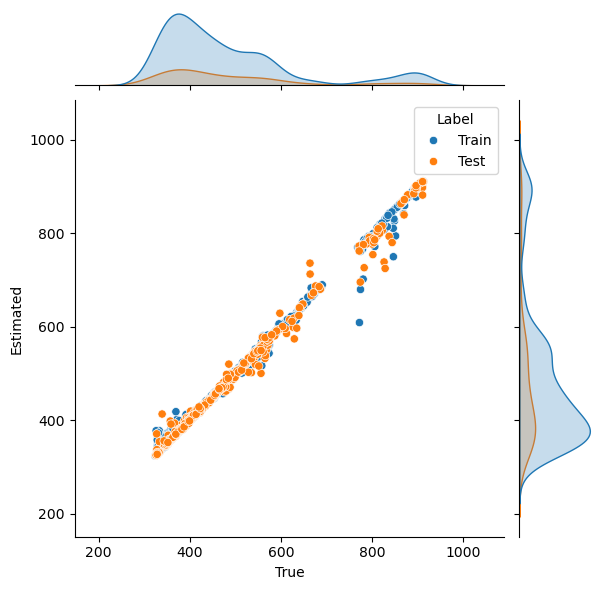

In [46]:
sns.jointplot(data=sns_df, x='True', y='Estimated', kind="scatter", hue='Label') 

plt.show()

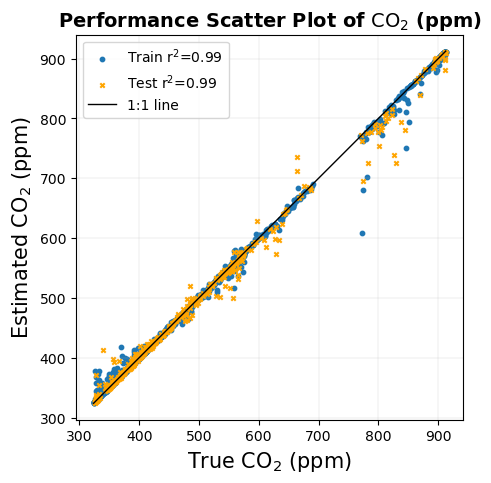

In [44]:
## Lets plot the scatter plot

import matplotlib as mpl

mpl.rcParams['mathtext.default']='regular'

plt.figure(figsize=(5,5))
plt.scatter(y_train, train_prediction_RF,s=10,c='C0',label="Train $r^2$={}".format(correlation_train))
plt.scatter(y_test, test_prediction_RF,marker='x',s=10,c='orange',label='Test $r^2$={}'.format(correlation_test))


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))
plt.plot([p1, p2], [p1, p2], 'black',label='1:1 line',linewidth=1)
plt.xlabel(r'True $\mathrm{CO_2}$ (ppm)', fontsize=15)
plt.ylabel(r'Estimated $\mathrm{CO_2}$ (ppm)', fontsize=15)
plt.axis('equal')
plt.title(r"Performance Scatter Plot of $\mathrm{CO_2}$ (ppm)", fontsize=14,fontweight="bold")
plt.legend()
plt.grid(axis='both',linewidth=0.15)
plt.show()

In [ ]:
## Lets plot the quantile quantile 

all_preds=np.concatenate((train_prediction_RF,test_prediction_RF)) ## the list of all predictions and target values
preds=np.sort(all_preds)
tars=target.sort_values()

## This helps in customizing the graph
import statsmodels.api as sm
import scipy.stats as stats

plt.rc("figure", figsize=(5,5)) ## to make same figure size in statsmodels.api

pp_x = sm.ProbPlot(preds, fit=False)
pp_y = sm.ProbPlot(tars, fit=False)
qq = pp_x.qqplot(xlabel=r'True $\mathrm{CO_2}$',ylabel=r'Estimated $\mathrm{CO_2}$',marker='x',markersize=4,other=pp_y)

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1)
                                 
tars_25=np.percentile(tars,25)  ## for the percentiles                                                        
tars_50=np.percentile(tars,50)
tars_75=np.percentile(tars,75)
tars_90=np.percentile(tars,90)


preds_25=np.percentile(preds,25)
preds_50=np.percentile(preds,50)
preds_75=np.percentile(preds,75)  
preds_90=np.percentile(tars,90)  ## end of percentiles

plt.plot(tars_25,preds_25,marker="D",markersize=5,color="orange",linestyle ='None',label=r"$\mathrm{25^{th}}$ Percentile")
plt.plot(tars_50,preds_50,marker="D",markersize=5,color="violet",linestyle ='None',label=r"$\mathrm{50^{th}}$ Percentile")
plt.plot(tars_75,preds_75,marker="D",markersize=5,color="Cyan",linestyle ='None',label=r"$\mathrm{75^{th}}$ Percentile")
plt.plot(tars_90,preds_90,marker="D",markersize=5,color="Green",linestyle ='None',label=r"$\mathrm{90^{th}}$ Percentile")


plt.grid(axis='both',linewidth=0.15)

plt. title(r'Quantile-Quantile plot of $\mathrm{CO_2}$ (ppm) ',fontsize=14,fontweight="bold")

plt.legend()
plt.show()

In [ ]:
## lets calculate the average values of RMSE

from statistics import mean

j_train=[]
j_test=[]
k_train=[]
k_test=[]

for i in range(0,20):    
    
    X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

    final_model.fit(X_train,y_train)

    train_prediction=final_model.predict(X_train)
    mse_train=mean_squared_error(y_train,train_prediction)
    rmse_train=np.sqrt(mse_train)
    j_train.append(rmse_train)
    
    test_prediction=final_model.predict(X_test)

    mse_test=mean_squared_error(y_test,test_prediction)
    rmse_test=np.sqrt(mse_test)
    j_test.append(rmse_test)

## lets calculate the average correlation    
  
    train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
    correlation_train=int(train_r_sq*100)/100 ## display just 2 of them
    k_train.append(correlation_train)
    
    test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
    correlation_test=int(test_r_sq*100)/100
    k_test.append(correlation_test)

average_train_rmse=mean(j_train)
average_test_rmse=mean(j_test)
    
average_train_rsq=mean(k_train)
average_test_rsq=mean(k_test)

print('The average train RMSE for CO2 is:::', '%.2f' % average_train_rmse)
print('The average test RMSE for CO2 is:::', '%.2f' % average_test_rmse)

print('The average train r square for CO2 is:::', '%.2f' % average_train_rsq)
print('The average test r square for CO2 is:::', '%.2f' % average_test_rsq)

In [ ]:
print('The test RMSE error in each of the trail is:::', j_test)

In [ ]:
test_rmse=pd.DataFrame(j_test, columns=['Test RMSE Error (ppm)'])
test_rmse

In [ ]:
print('The r^2 in each of the trail in test set is:::', k_test)

In [ ]:
test_r2=pd.DataFrame(k_test, columns=['R$^2$ in test set'])
test_r2

In [17]:
penguins = sns.load_dataset("penguins")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


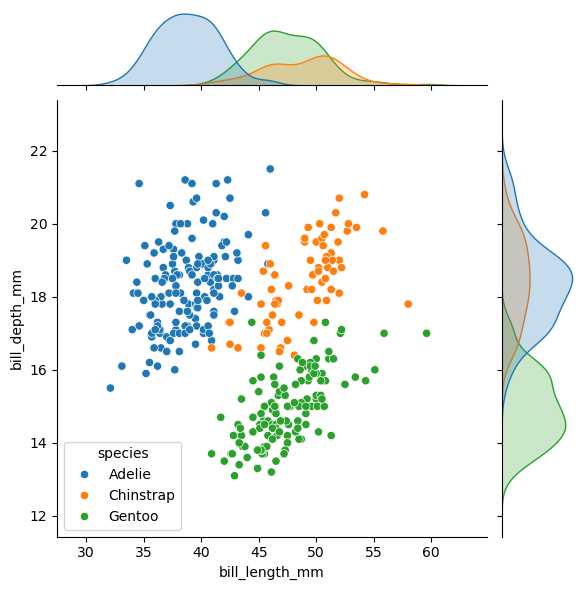

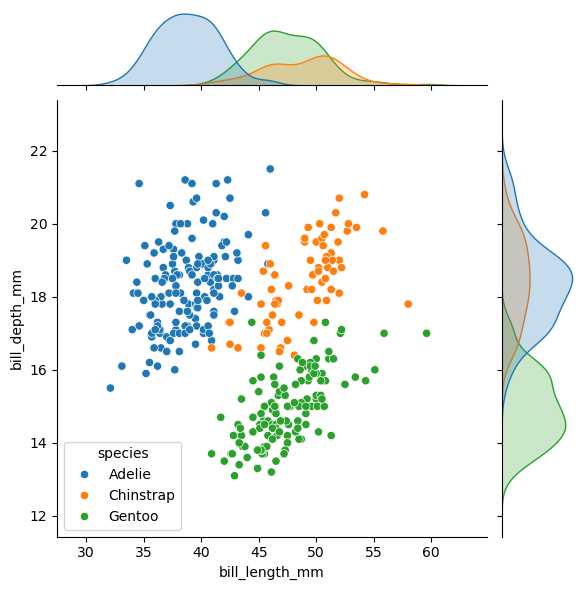

In [19]:
sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species")
plt.show()